In [19]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, timeit
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'
# from tqdm.auto import tqdm, trange
from collections import OrderedDict, deque, defaultdict
from pathlib import Path

import torch
import numpy as np, pandas as pd, scipy
from scipy.stats import zscore
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score

import umap.umap_ as umap

torch.set_num_threads(4)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
# plt.rcParams['font.family'] = "Liberation Sans"
# plt.rcParams['font.size'] = 16
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
pip uninstall umap

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Would remove:
    /opt/conda/lib/python3.8/site-packages/umap-0.1.1.dist-info/*
    /opt/conda/lib/python3.8/site-packages/umap/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install umap-learn

     |████████████████████████████████| 80 kB 133 kB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 54 kB/s eta 0:00:015     |█████████████████▍              | 614 kB 105 kB/s eta 0:00:05
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=19b95bdf395a25e8763f0e9cec49b7c0c8648eae546524e386b7dff573d82240
  Stored in directory: /home/jovyan/.cache/pip/wheels/95/85/b7/b4b7040e49367b6d1505d7e8fb57e3e79b22fa6ac26f72520b
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52587 sha256=c40d97720a683ccd8d7c0860698e39afdd917eaa56d6fbdb00d29551b0b52c04
  Stored in directory: /home/jovyan/.cache/pip/wheels/e4/0e/b5/07c0c231aacb04e5d1046fe7459bb27ea79f95b5edbe88e435
Successfully built umap-learn pynndescent
Note: you may need to restart the kernel to use updated packages.


In [20]:
# no need to restart the notebook after updating any .py files
def reload_all():
    import evaluation
    importlib.reload(evaluation)

reload_all()

In [21]:
# generate simulated data of 100 cells
# the # of embedding dimensions is 5
# the first 50 cells are from cell type A and their embeddings are drawn from N(0, 1)
# the other 50 cells are from cell type B and their embeddings are drawn from N(2, 1)
embedding = np.random.randn(100, 5)
embedding[50:] += 2

In [22]:
# further reduce dimension by UMAP
embedding_viz = umap.UMAP(min_dist=.1, n_neighbors=15).fit_transform(embedding)

/opt/conda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [23]:
# create two labels for each cell
labels = pd.DataFrame({
    'cell type': ['A']*50 + ['B']*50,
    'random': np.random.choice(2, size=100, replace=True),
})
print(labels)

   cell type  random
0          A       0
1          A       0
2          A       0
3          A       0
4          A       0
..       ...     ...
95         B       0
96         B       0
97         B       1
98         B       0
99         B       1

[100 rows x 2 columns]


cell type	sil = 0.45	mod = 0.92
random	sil = -0.00	mod = -0.03


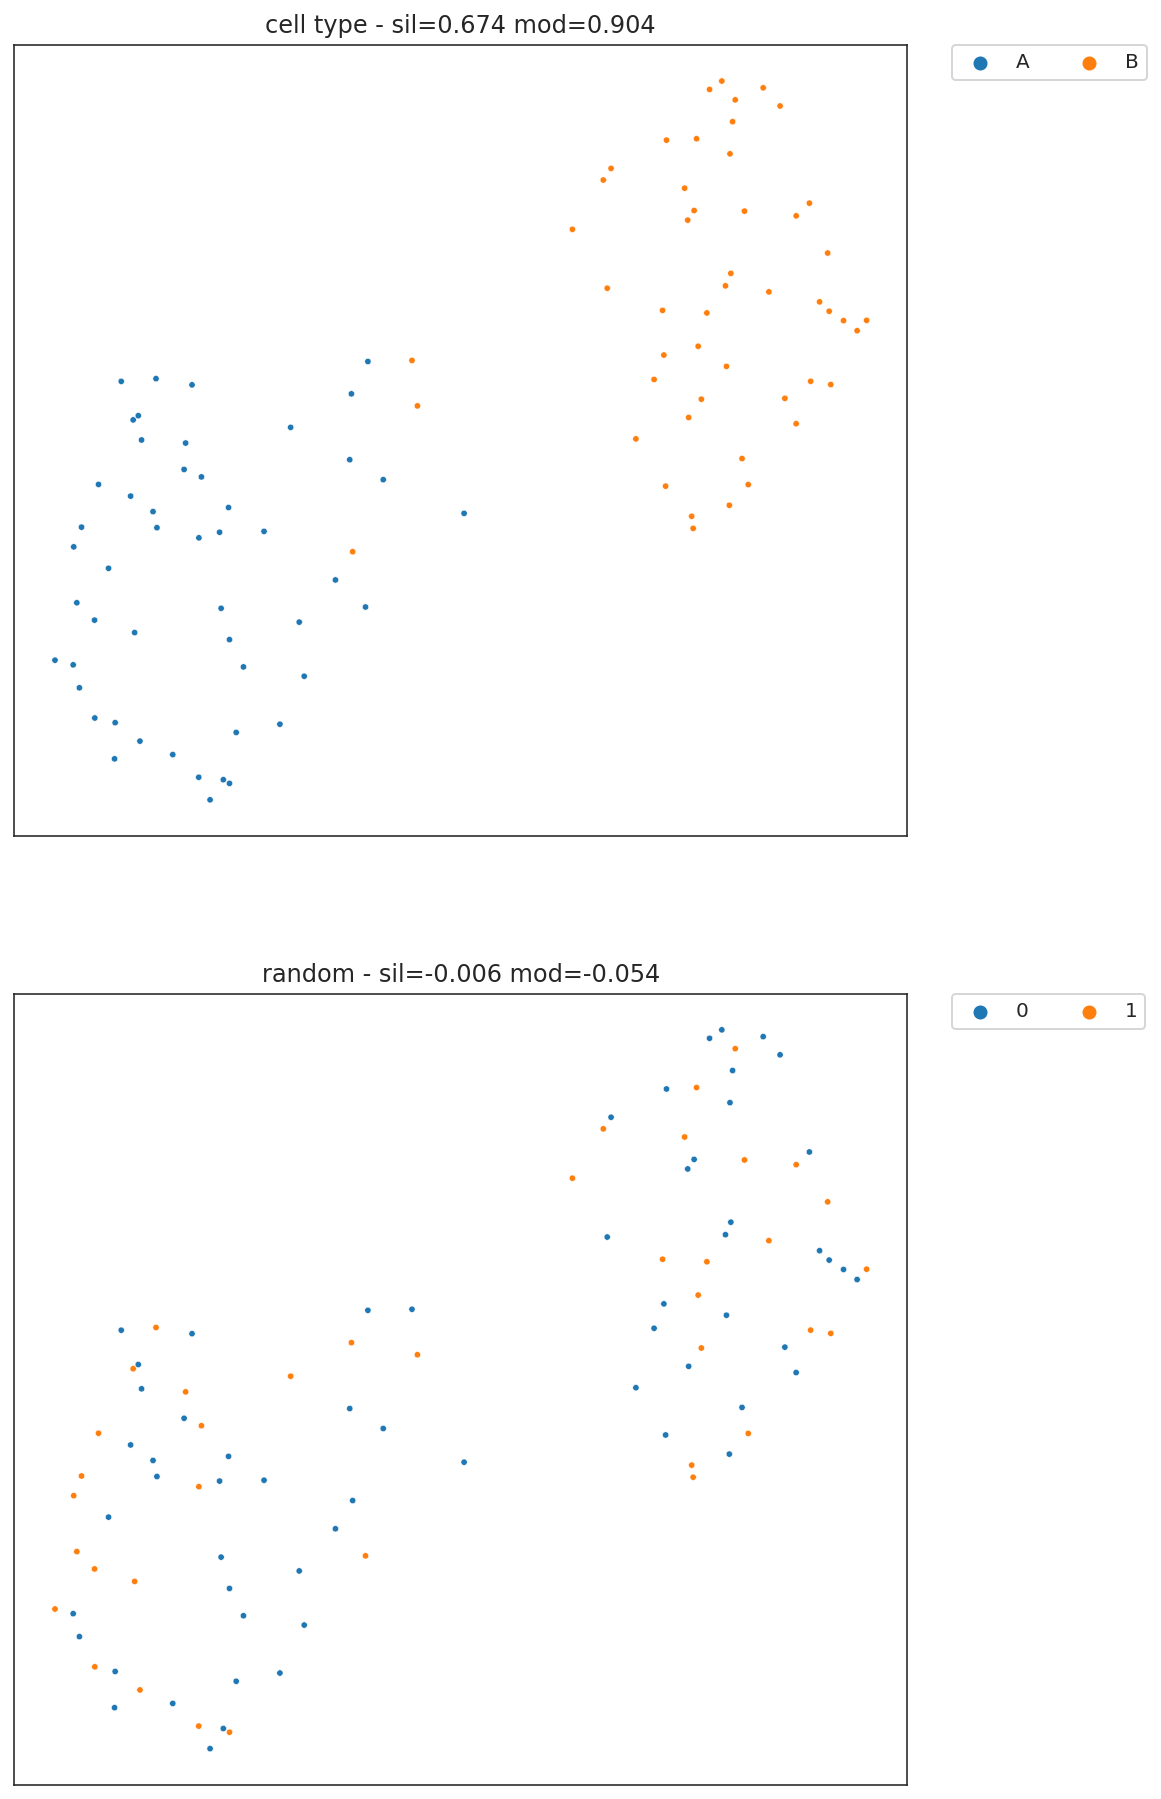

In [24]:
reload_all()
from evaluation import evaluate_embedding, evaluate_embedding_viz

# first evaluate the original embedding
for label_name, label in labels.iteritems():
    label = label.values
    scores = evaluate_embedding(embedding, label)
    print(f'{label_name}\t' + '\t'.join(f'{k[:3]} = {s:.2f}' for k, s in scores.items()))

# now visualize and evaluate the 2-D UMAP embedding
scores = evaluate_embedding_viz(
    embedding_viz, labels,
    kwargs_plot=dict(
        s=10, # marker size
    )
)